# Objetivo do notebook é aplicar os conceitos apresentados no paper "Mean–variance portfolio optimization using machine learning-based", de Wei Chen et. all.

## [Link](https://sci-hub.se/10.1016/j.asoc.2020.106943 "Artigo")

In [1]:
from fa import *
from tunning import *
import time
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
#from fa import *
style.use('ggplot')

from sklearn.model_selection import  GridSearchCV

import xgboost as xgb
import warnings
warnings.filterwarnings(action='ignore')


# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV


#from stldecompose import decompose

# Chart drawing
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import  init_notebook_mode

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'


In [2]:
my_path = "C:\\Users\\victo\\Documents\\Digital House DS\\projetoIntegrador\\Projeto Integrador"

Pega o dataset de ativos

In [3]:

df_ativos = pd.read_csv(my_path+"\\data\\processed\\ativos_paper_com_lag.csv")
df_ativos = df_ativos.rename(columns={"Unnamed: 0":"Date"})
df_ativos.set_index("Date")

,Open,High,Low,Close,Adj Close,Volume,Ativo,1: ln(C/C-1),2: ln(C-1/C-2),3: ln(C-2/C-3),...,10: ln(H-2/O-2),11: ln(H-3/O-3),12: ln(L/O),13: ln(L-1/O-1),14: ln(L-2/O-2),15: ln(L-3/O-3),16: True Range,17: ATR 14d,18: MI 10d,19: RSI 14d
Date,,,,,,,,,,,,,,,,,,,,,
2009-11-02,8.772292,9.632970,8.722638,9.504696,6.291415,265173584,600000.SS,NaN,NaN,NaN,...,NaN,NaN,-0.005676,NaN,NaN,NaN,0.910332,NaN,NaN,NaN
2009-11-03,9.517110,9.661935,9.475731,9.587453,6.346194,207655706,600000.SS,0.008669,NaN,NaN,...,NaN,NaN,-0.004357,-0.005676,NaN,NaN,0.186204,NaN,NaN,NaN
2009-11-04,9.562626,9.968138,9.521247,9.794347,6.483143,235029795,600000.SS,0.021350,0.008669,NaN,...,0.093593,NaN,-0.004337,-0.004357,-0.005676,NaN,0.446891,NaN,NaN,NaN
2009-11-05,9.757106,9.889518,9.670211,9.744693,6.450275,126982654,600000.SS,-0.005083,0.021350,0.008669,...,0.015103,0.093593,-0.008946,-0.004337,-0.004357,-0.005676,0.219307,NaN,NaN,NaN
2009-11-06,9.848140,9.992965,9.724003,9.777796,6.472187,154066548,600000.SS,0.003391,-0.005083,0.021350,...,0.041531,0.015103,-0.012685,-0.008946,-0.004337,-0.004357,0.268962,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25,3.610000,3.660000,3.610000,3.650000,3.256570,85133202,601988.SS,0.011019,-0.005525,0.002759,...,0.002759,0.002759,0.000000,-0.005525,-0.005540,0.000000,0.050000,0.036429,0.01,NaN
2019-11-26,3.660000,3.680000,3.640000,3.670000,3.274414,149997057,601988.SS,0.005464,0.011019,-0.005525,...,0.002751,0.002759,-0.005479,0.000000,-0.005525,-0.005540,0.040000,0.035714,0.01,NaN
2019-11-27,3.670000,3.670000,3.650000,3.660000,3.265492,47606200,601988.SS,-0.002729,0.005464,0.011019,...,0.013755,0.002751,-0.005464,-0.005479,0.000000,-0.005525,0.020000,0.035000,0.01,NaN


In [4]:

def relative_strength_idx(close, n=14):
    delta = close.diff()
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
def get_ativos(df, ativo):
    df = df[df['Ativo'] == ativo]
    df['19: RSI 14d'] = relative_strength_idx(df['Close'])
    df['Close'] = df.loc[:,'Close'].shift(-1)
    #Gera um NA, então vamos ter que dropar novamente...
    df.dropna(inplace=True)
    list_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume',	'Ativo','Date']
    df = df.drop(columns = list_drop)
    return df

In [6]:
ativo = '600000.SS'

In [7]:

#Setup inital parameters

best_param = {
"learning_rate" : 0.1,
"n_estimator" : 1000,
"max_depth" : 5,
"min_child_weight" : 1,
"gamma" : 0,
"colsample_bytree" : 0.8,
"subsample" : 0.8,
"objective" : 'reg:squarederror',
"reg_lambda":0,
"reg_alpha":0.5,
"nthread" : 4,
"seed" : 248
}

def get_new_xgboost():
    return xgb.XGBRegressor(
         learning_rate = best_param['learning_rate'],
         n_estimators= best_param['n_estimator'],
         max_depth= best_param['max_depth'],
         min_child_weight= best_param['min_child_weight'],
         gamma= best_param['gamma'],
         colsample_bytree= best_param['colsample_bytree'],
         subsample = best_param['subsample'],
         objective= best_param['objective'],
         reg_alpha = best_param['reg_alpha'],
         reg_lambda = best_param['reg_lambda'],
         nthread= best_param['nthread'],
         seed= 248)


In [8]:
def update_best_param(new_param):
    for key, value in new_param.items():
        best_param[key] = new_param[key]

## Análise de Tunning dos modelos do Ativo 600000

# Definindo uma função para rodar modelo, mostrar resultados e plotar feature importance, além de armazenar tudo num DF:

In [9]:
cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
cols_results = ['MAPE_train', 'MAPE_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test', 'RMSE_train', 'RMSE_test','tunning_method', 'time', 'n_folds']
cols_params.extend(cols_results)
df_model = pd.DataFrame(columns = cols_params)
df_model

,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_alpha,reg_lambda,MAPE_train,MAPE_test,MSE_train,MSE_test,MAE_train,MAE_test,RMSE_train,RMSE_test,tunning_method,time,n_folds


In [10]:
# Créditos: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def model_fit(estimator, dtrain, dtest, features, target, dmodel, cv_folds=10, early_stopping_rounds=50, tunning_method = 'None'):
    
    xgb_param = estimator.get_xgb_params()
    
    xgtrain = xgb.DMatrix(data = dtrain[features].values, label = dtrain[target].values)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = estimator.get_params()['n_estimators'], nfold = cv_folds,
                      metrics ='rmse', early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
    
    estimator.set_params(n_estimators=cvresult.shape[0])
    
  
        
    
    #Fit the algorithm on the data
    
    estimator.fit(dtrain[features], dtrain[target], eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = estimator.predict(dtrain[features])
    
        
    #Printar resultados no treino:
    print ("\nResultados do modelo no treino")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(df_train['Disbursed'].values, df_train_predictions))
    
    #MAPE = mean_absolute_percentage_error(y_true = y_train['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_train = np.mean(np.abs((dtrain[target].values - dtrain_predictions)/dtrain[target].values))
    MSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = False)
    MAE_train = mean_absolute_error(y_true = dtrain[target].values, y_pred = dtrain_predictions)
    RMSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = True)
    
    print(f'MAPE = {MAPE_train:.4f}')
    print(f'MSE = {MSE_train:.4f}')
    print(f'MAE = {MAE_train:.4f}')
    print(f'RMSE = {RMSE_train:.4f}')
    
    
    #Prever e printar resultados no teste:
    
    dtest_predictions = estimator.predict(dtest[features])
    
    #MAPE = mean_absolute_percentage_error(y_true = y_train['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_test = np.mean(np.abs((dtest[target].values - dtest_predictions)/dtest[target].values))
    MSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = False)
    MAE_test = mean_absolute_error(y_true = dtest[target].values, y_pred = dtest_predictions)
    RMSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = True)

    print ("\nResultados do modelo no teste")
    print(f'MAPE = {MAPE_test:.4f}')
    print(f'MSE = {MSE_test:.4f}')
    print(f'MAE = {MAE_test:.4f}')
    print(f'RMSE = {RMSE_test:.4f}')
    
   
    
    #Plotar gráfico treino e teste:
    
    print ("\n")
    print ("Time Series de treino e teste:")

    plt.rcParams["figure.figsize"] = (100, 20)
    fig = make_subplots(rows=3, cols=1, )

    fig.add_trace(go.Scatter(x = dtrain.index, y = dtrain[target].values,
                             name='Real - Treino',
                             marker_color='Green'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtrain.index,
                             y = dtrain_predictions,
                             name='Predição - Treino',
                             marker_color='DarkBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtest.index, y = dtest[target].values,
                             name='Real - Teste',
                             marker_color='Green'), row=3, col=1)

    fig.add_trace(go.Scatter(x = dtest.index,
                             y = dtest_predictions,
                             name='Predição - Teste',
                             marker_color='DarkBlue'), row=3, col=1)

    fig.show()
    
     
    #Plotar feature importance:
    
    print ("\n")
    plt.rcParams["figure.figsize"] = (20, 10)
    plot_importance(estimator, height = 0.5)
    
    #Armazenando os parâmetros e resultados em um DF:
    
    params_results = []
    
    cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
    
    for i in range(len(cols_params)):
        params_results.append(estimator.get_params()[cols_params[i]])
    
    params_results.extend([MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test, tunning_method])
    
    dmodel.loc[len(dmodel)] = params_results
    print ("DataFrame consolidado de parâmetros e resultados tentados até aqui:")
    
    return dmodel
    

In [11]:
# Créditos: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def model_fit_xgboost(time, tunning_method = 'None'):
    cv_folds=5 
    early_stopping_rounds=50
    features = X_train.columns
    target = 'Close'
    estimator = get_new_xgboost()
    xgb_param = estimator.get_xgb_params()
    
    xgtrain = xgb.DMatrix(data = dtrain[features].values, label = dtrain[target].values)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = estimator.get_params()['n_estimators'], nfold = cv_folds,
                      metrics ='rmse', early_stopping_rounds = early_stopping_rounds, verbose_eval = True)
    
    estimator.set_params(n_estimators=cvresult.shape[0])
    print("Model Fit XGBoost estimator param:{}".format(estimator.get_xgb_params()))
  
        
    
    #Fit the algorithm on the data
    
    estimator.fit(dtrain[features], dtrain[target], eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = estimator.predict(dtrain[features])
    
        
    #Printar resultados no treino:
    print ("\nResultados do modelo no treino")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(df_train['Disbursed'].values, df_train_predictions))
    
    #MAPE = mean_absolute_percentage_error(y_true = y_train['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_train = np.mean(np.abs((dtrain[target].values - dtrain_predictions)/dtrain[target].values))
    MSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = False)
    MAE_train = mean_absolute_error(y_true = dtrain[target].values, y_pred = dtrain_predictions)
    RMSE_train = mean_squared_error(y_true = dtrain[target].values, y_pred = dtrain_predictions, squared = True)
    
    #print(f'MAPE = {MAPE_train:.4f}')
    #print(f'MSE = {MSE_train:.4f}')
    #print(f'MAE = {MAE_train:.4f}')
    #print(f'RMSE = {RMSE_train:.4f}')
    
    
    #Prever e printar resultados no teste:
    
    dtest_predictions = estimator.predict(dtest[features])
    
    #MAPE = mean_absolute_percentage_error(y_true = y_train['Close'], y_pred = y_pred_test) -> Fazer na mão grande
    MAPE_test = np.mean(np.abs((dtest[target].values - dtest_predictions)/dtest[target].values))
    MSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = False)
    MAE_test = mean_absolute_error(y_true = dtest[target].values, y_pred = dtest_predictions)
    RMSE_test = mean_squared_error(y_true = dtest[target].values, y_pred = dtest_predictions, squared = True)

    #print ("\nResultados do modelo no teste")
    ##print(f'MAPE = {MAPE_test:.4f}')
    #print(f'MSE = {MSE_test:.4f}')
    #print(f'MAE = {MAE_test:.4f}')
    #print(f'RMSE = {RMSE_test:.4f}')
    
   
    
    #Plotar gráfico treino e teste:
    
    print ("\n")
    print ("Time Series de treino e teste:")

    plt.rcParams["figure.figsize"] = (100, 20)
    fig = make_subplots(rows=3, cols=1, )

    fig.add_trace(go.Scatter(x = dtrain.index, y = dtrain[target].values,
                             name='Real - Treino',
                             marker_color='Green'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtrain.index,
                             y = dtrain_predictions,
                             name='Predição - Treino',
                             marker_color='DarkBlue'), row=1, col=1)

    fig.add_trace(go.Scatter(x = dtest.index, y = dtest[target].values,
                             name='Real - Teste',
                             marker_color='Green'), row=3, col=1)

    fig.add_trace(go.Scatter(x = dtest.index,
                             y = dtest_predictions,
                             name='Predição - Teste',
                             marker_color='DarkBlue'), row=3, col=1)

    fig.show()
    
     
    #Plotar feature importance:
    
    print ("\n")
    plt.rcParams["figure.figsize"] = (20, 10)
    plot_importance(estimator, height = 0.5)
    
    #Armazenando os parâmetros e resultados em um DF:
    
    params_results = []
    
    cols_params=['learning_rate', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'reg_alpha', 'reg_lambda'] 
    
    for i in range(len(cols_params)):
        params_results.append(estimator.get_params()[cols_params[i]])
    
    params_results.extend([MAPE_train, MAPE_test, MSE_train, MSE_test, MAE_train, MAE_test, RMSE_train, RMSE_test, tunning_method, time, cv_folds])
    
    df_model.loc[len(df_model)] = params_results
    print ("DataFrame consolidado de parâmetros e resultados tentados até aqui:")
    
    return df_model
    

In [12]:
def find_best_paramater(xgboost_estimator, param_test, X_train, y_train ):
    halvingGrid = HalvingGridSearchCV(estimator = xgboost_estimator, param_grid = param_test, n_jobs=-1, cv=TimeSeriesSplit(), verbose=2)
    halvingGrid.fit(X_train, y_train)
    print("Best Params{}\nFinalParam{}\nBestScore:{}".format(halvingGrid.cv_results_['params'], halvingGrid.best_params_, halvingGrid.best_score_))

In [13]:
def get_gridSearch_best_param(xgboost_estimator, param_test):
    gsearch = GridSearchCV(estimator = xgboost_estimator, 
                         param_grid = param_test, n_jobs= -1, cv=TimeSeriesSplit(n_splits=3), verbose=2)

    gsearch.fit(X_train, y_train)
    gsearch.cv_results_['params'], gsearch.best_params_, gsearch.best_score_
    return gsearch.best_params_


In [14]:
def get_halvingSearch_best_param(estimator, param_test):
    halvingGrid = HalvingGridSearchCV(estimator = estimator, param_grid = param_test, n_jobs=-1, cv=TimeSeriesSplit(n_splits=3), verbose=2)
    halvingGrid.fit(X_train, y_train)
    halvingGrid.cv_results_['params'], halvingGrid.best_params_
    return halvingGrid.best_params_

In [15]:
df = get_ativos(df_ativos, ativo)

In [16]:
test_size = 0.2
test_split_idx  = int(df.shape[0] * (1-test_size))
dtrain  = df.iloc[:test_split_idx].copy()
dtest   = df.iloc[test_split_idx+1:].copy()
X_train = dtrain.drop(columns=['Close'])
y_train = dtrain['Close']
X_test = dtest.drop(columns=['Close'])
y_test = dtest['Close']

## Step 1: Fix learning rate (aka "eta") and number of estimators for tuning tree-based parameters

In [ ]:
#Vamos setar learning_rate para 0.1 e n_etimators para 1000. A ideia é tunar apenas os parâmetros específicos de árvores, que vão começar como segue:

xgb1 = get_new_xgboost()

model_fit(estimator = xgb1, dtrain = dtrain, dtest = dtest, features = X_train.columns, target = 'Close', dmodel = df_model, cv_folds=5, early_stopping_rounds=50)

Como o erro continuou caindo até o 368º estimador, vamos atribuir esse valor a n_estimator. Percebemos que há claramente um overfitting quando observamos a série temporal de treino.

## Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

In [ ]:
param_test1 = {
 'max_depth':range(1,15,2),
 'min_child_weight':range(1,10,2)
}

In [ ]:
get_gridSearch_best_param(get_new_xgboost(), param_test1)
update_best_param({'max_depth': 3, 'min_child_weight': 9})
model_fit_xgboost('GridSearch')

In [ ]:
model_fit_xgboost('GridSearch')

Encontramos os melhores valores. Para aprofundar, vamos aumentar a granularidade do teste variando os best_params em +1 e -1.

In [ ]:
param_test2 = {
 'max_depth':[1, 2, 3,4,5],
 'min_child_weight':[1, 2, 3,4,5]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test2)
update_best_param(result)
model_fit_xgboost('GridSearch')

Permanecemos com os valores encontrados como os melhores parâmetros.

## Step 3: Tune gamma
Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here. 

In [ ]:
param_test3 = {
 'gamma':[i/10 for i in range(0,10)]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test3)
update_best_param(result)
model_fit_xgboost('GridSearch')

gamma = 0.0 se mostrou um bom valor. Agora que fizemos esse passo, é importante reavaliar o n_estimators. Vamos lá:

"n_estimators" deve continumar com o valor 368, já que o aumento da quantidade de árvores não se justifica pela diminuição no erro.

## Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values. Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [ ]:
param_test4 = {
 'subsample':[i/10 for i in range(6,10)],
 'colsample_bytree':[i/10 for i in range(6,10)]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test4)
update_best_param(result)
model_fit_xgboost('GridSearch')

Agora que encontramos os melhores valores, vamos aumentar a granularidade para 0.05 e observar:

In [ ]:
param_test4 = {
 'subsample':[i/100 for i in range(75,90,5)],
 'colsample_bytree':[i/100 for i in range(85,100,5)]
}


In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test4)
update_best_param(result)
model_fit_xgboost('GridSearch')

Valores não se alteraram. Definimos, então:
colsample_bytree = 0.9 ;
subsample = 0.8

## Step 5: Tuning Regularization Parameters
Next step is to apply regularization to reduce overfitting. Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to try different values of ‘reg_lambda’.

In [ ]:
param_test5 = {
 'reg_alpha':[0, 1e-4, 1e-2, 0.1, 1, 100]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test5)
update_best_param(result)
model_fit_xgboost('GridSearch')

Aparentemente, o alpha ideal deve ser pequeno, da ordem de 0.1. Vamos explorar um pouco mais aumentando a granularidade:

In [ ]:
param_test7 = {
 'reg_alpha':[8e-2, 5e-2, 1e-1, 3e-1, 5e-1]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test7)
update_best_param(result)
model_fit_xgboost('GridSearch')

reg_alpha = 0.05 confirmou ser o melhor valor.
Agora vamos rodar mais uma vez o modelo, dessa vez aumentando o n_estimators para avaliar o número ideal:

Ainda bastante overfitado... n_estimators poderia adotar o valor de 534. Vamos checar o reg_lambda.

### Explorando o reg_lambda:

In [ ]:
param_test6 = {
 'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test6)
update_best_param(result)
model_fit_xgboost('GridSearch')

Opa... lambda 100 é o melhor valor até então. Vamos aumentar um pouco mais esse range em torno desse valor, para verificar:

In [ ]:
param_test9 = {
 'reg_lambda':[90, 100, 500, 1000, 2000, 2500]
}

In [ ]:
param_test9 = {
 'reg_lambda':[90, 100, 500, 1000, 2000, 2500]
}
result = get_gridSearch_best_param(get_new_xgboost(), param_test9)
update_best_param(result)
model_fit_xgboost('GridSearch')

Não faz muito sentido ter um lambda tão alto... Explorar isso depois

## Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Let's use the cv function of XGBoost to do the job again.

In [ ]:
result = get_gridSearch_best_param(get_new_xgboost(), param_test6)
update_best_param({"learning_rate":0.01})
model_fit_xgboost('GridSearch')



# Testing with Halving Grid Search

In [ ]:
def tunning_and_fit(param, tunning_method):
    start = time.time()
    result = get_halvingSearch_best_param(get_new_xgboost(), param)
    end = time.time()
    update_best_param(result)
    total_time = end - start
    return model_fit_xgboost(total_time, tunning_method)

In [ ]:
def reset_best_param():
    best_param = {
    "learning_rate" : 0.1,
    "n_estimator" : 1000,
    "max_depth" : 5,
    "min_child_weight" : 1,
    "gamma" : 0,
    "colsample_bytree" : 0.8,
    "subsample" : 0.8,
    "objective" : 'reg:squarederror',
    "nthread" : 4,
    "seed" : 248
    }
    update_best_param(best_param)


In [ ]:
reset_best_param()

## Max depth and min_child_weight

In [ ]:
param_test1 = {
 'max_depth':range(1,15,2),
 'min_child_weight':range(1,10,2)
}

In [ ]:
tunning_and_fit(param_test1, 'HalvingGrid Dual Parameter')

## Tune Gamma

In [ ]:
param_test3 = {
 'gamma':[i/10 for i in range(0,10)]
}
tunning_and_fit(param_test3, 'HalvinGrid Single Parameter')

## Tune subsample and colsampl_bytree

In [ ]:
param_test4 = {
 'subsample':[i/10 for i in range(6,10)],
 'colsample_bytree':[i/10 for i in range(6,10)]
}
tunning_and_fit(param_test4, 'HalvinGrid Dual Parameter')

## Tune Regularization Param

In [ ]:
param_test = {
 'reg_alpha':[8e-2, 5e-2, 1e-1, 3e-1, 5e-1],
 'reg_lambda':[90, 100, 500, 1000, 2000, 2500]
}
tunning_and_fit(param_test, 'HalvinGrid Dual Parameter')

## Reducing Learning Rate

In [ ]:
param_test = {
 'learning_rate':[i/10 for i in range(0,10)]
}
tunning_and_fit(param_test, 'HalvinGrid Single Parameter')

# Get All Parameter at once

In [ ]:
reset_best_param()

In [ ]:
all_param ={
'max_depth':range(1,15,5),
'min_child_weight':range(1,10,5),
'gamma':[i/10 for i in range(0,10)],
'subsample':[i/100 for i in range(75,90,5)],
'colsample_bytree':[i/100 for i in range(85,100,5)],
'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100],
'reg_alpha':[8e-2, 5e-2, 1e-1, 3e-1, 5e-1]
}

'subsample':[i/100 for i in range(75,90,5)],
'colsample_bytree':[i/100 for i in range(85,100,5)],
'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100],
'reg_alpha':[0, 1e-4, 1e-2, 0.1, 1, 100]


In [ ]:
tunning_and_fit(all_param, 'HalvinGrid All Parameter')

# Testing FA

## Fitness Function

In [ ]:
def Fitness_function(D, fireFly):
    estimator = xgb.XGBRegressor(
         learning_rate = fireFly[0],
         max_depth= int(fireFly[1]),
         min_child_weight= fireFly[2],
         gamma= fireFly[3],
         colsample_bytree= fireFly[4],
         subsample = fireFly[5],
         reg_alpha = fireFly[6],
         reg_lambda = fireFly[7],
         seed= 248)
    n_fold = 5
    tscv = TimeSeriesSplit(n_splits=n_fold)
    mape = 0
    for train_index, test_index in tscv.split(df):
        new_x_train = df.loc[train_index].drop(columns=['Close'])
        new_y_train = df.loc[train_index]['Close']

        new_x_test = df.loc[test_index].drop(columns=['Close'])
        new_y_test = df.loc[test_index]['Close']

        estimator.fit(new_x_train, new_y_train, eval_metric='rmse')
        
        y_predict = estimator.predict(new_x_test)
        MAPE_test = np.mean(np.abs((new_y_test.values - y_predict)/new_y_test.values))
        mape += MAPE_test
        #print("Mape:{}\n".format(MAPE_test))
    #print("Final Mape:{}".format(mape/n_fold))
    return mape/n_fold



In [17]:
df = df.reset_index(drop=True)

In [18]:
tscv = TimeSeriesSplit(n_splits=3)
df = df.reset_index(drop=True)


## Testing

In [19]:
# DONT CHANGE THE ORDER OF THE PARAMETERS, IT WILL CRASH
parameters = {
    "learning_rate" :[0.3, 0.5],
    "max_depth" : [3, 5],
    "min_child_weight" :[0.5, 10],
    "gamma": [0, 5],
    "colsample_bytree": [0.5, 1],
    "subsample" :[0.8, 1],
    "reg_alpha" : [1e-2, 1],
    "reg_lambda" : [1e-4, 1],
    "n_estimators": [50, 400]
}

fa = Tunning_FA(df, 'Close', parameters)
fa.Run()

Best Fitness:0.1838076493519242
Best Param:[0.485961784916076, 3.9460065798434196, 4.230063124056056, 0.9015783965318469, 0.5629010228124562, 0.9027999085268188, 0.8544871813095197, 0.24278905607463297, 214.3004464274993]


Best Fitness:0.1838076493519242
Best Param:[0.4296824436626887, 3.5296832605479116, 7.861168657794772, 1.2785434560605147, 0.8376719557411612, 0.9796607092477908, 0.04056055757438153, 0.06753037220717213, 219.07213463771987]


Best Fitness:0.1838076493519242
Best Param:[0.4296824436626887, 3.5296832605479116, 7.861168657794772, 1.2785434560605147, 0.8376719557411612, 0.9796607092477908, 0.04056055757438153, 0.06753037220717213, 219.07213463771987]


Best Fitness:0.1838076493519242
Best Param:[0.4296824436626887, 3.5296832605479116, 7.861168657794772, 1.2785434560605147, 0.8376719557411612, 0.9796607092477908, 0.04056055757438153, 0.06753037220717213, 219.07213463771987]


Best Fitness:0.18342358035203368
Best Param:[0.4059617240011893, 3.9273421361232335, 6.44511194

{'learning_rate': 0.41070559668652357,
 'max_depth': 3,
 'min_child_weight': 6.7283112474793345,
 'gamma': 1.2024991292908354,
 'colsample_bytree': 0.8306869056161891,
 'subsample': 0.9202617829227263,
 'reg_alpha': 0.1166489526428796,
 'reg_lambda': 0.34878671838981334,
 'n_estimators': 275}

[0]	train-rmse:5.46614+0.02116	test-rmse:5.47172+0.10560
[1]	train-rmse:3.65659+0.01662	test-rmse:3.70037+0.10140
[2]	train-rmse:2.67495+0.02113	test-rmse:2.78554+0.09418
[3]	train-rmse:2.15874+0.04975	test-rmse:2.30985+0.08325
[4]	train-rmse:1.88734+0.05750	test-rmse:2.07863+0.07990
[5]	train-rmse:1.74376+0.06629	test-rmse:1.94530+0.07261
[6]	train-rmse:1.63605+0.07002	test-rmse:1.86560+0.07975
[7]	train-rmse:1.56279+0.07443	test-rmse:1.80922+0.07257
[8]	train-rmse:1.48576+0.07669	test-rmse:1.75078+0.06511
[9]	train-rmse:1.42433+0.07935	test-rmse:1.70099+0.07133
[10]	train-rmse:1.37849+0.07453	test-rmse:1.66568+0.07097
[11]	train-rmse:1.32165+0.07460	test-rmse:1.62495+0.05376
[12]	train-rmse:1.28397+0.07018	test-rmse:1.60433+0.05885
[13]	train-rmse:1.23927+0.06064	test-rmse:1.57036+0.06796
[14]	train-rmse:1.20676+0.06119	test-rmse:1.54632+0.06536
[15]	train-rmse:1.18122+0.06140	test-rmse:1.53318+0.05985
[16]	train-rmse:1.15814+0.06005	test-rmse:1.51545+0.05417
[17]	train-rmse:1.12612+



DataFrame consolidado de parâmetros e resultados tentados até aqui:


,learning_rate,n_estimators,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_alpha,reg_lambda,MAPE_train,MAPE_test,MSE_train,MSE_test,MAE_train,MAE_test,RMSE_train,RMSE_test,tunning_method,time,n_folds
0,0.410706,465,3,6.728311,1.202499,0.920262,0.830687,0.116649,0.348787,0.033426,0.078175,0.356566,1.120046,0.275897,0.88424,0.127139,1.254502,FA,251.329467,5


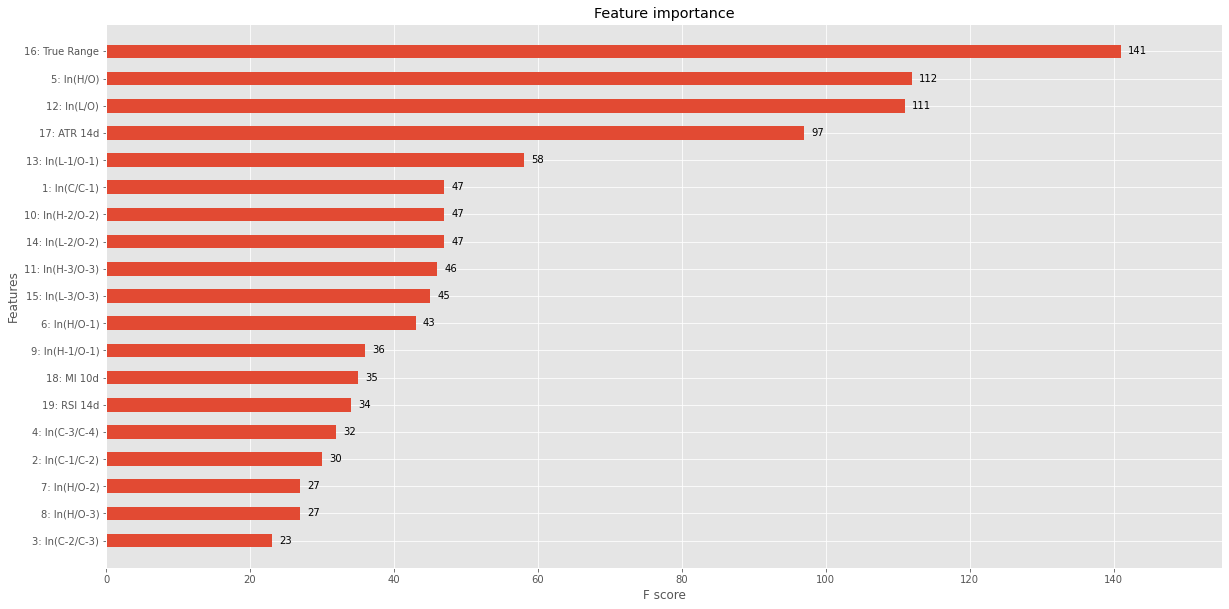

In [21]:
update_best_param(fa.best_firefly)
model_fit_xgboost(fa.time, tunning_method="FA")

In [ ]:
def tunning_and_fit_firefly(n_dimension, n_population, n_interactions, alpha, betamin, gamma, lower_boundary, upper_boundary):
    start = time.time()
    alg = NewFireflyAlgorithm(n_dimension, n_population, n_interactions, alpha , betamin , gamma , lower_boundary, upper_boundary, Fitness_function)
    end = time.end()
    total_time = end - start
    best_score, best_fireflies, best_index = alg.Run()
    fireFly = best_fireflies[best_index[0]]
    new_param = {
        "learning_rate" = fireFly[0],
        "max_depth"= int(fireFly[1]),
        "min_child_weight"= fireFly[2],
        "gamma"= fireFly[3],
        "colsample_bytree"= fireFly[4],
        "subsample" = fireFly[5],
        "reg_alpha" = fireFly[6],
        "reg_lambda" = fireFly[7]
    }
    update_best_param(new_param)
    model_fit_xgboost(total_time, 'FA')


In [ ]:
#
lower_boundary = [0.1, 3, 1, 0, 0.8, 0.6, 0, 1e-5]
upper_boundary = [0.5, 7, 3, 0.1, 1, 1, 1e-3, 5e-2]
n_dimension = 8
n_population = 100
n_interactions = 2000
alpha = 1
betamin = 0.2

tunning_and_fit_firefly(n_dimension, n_population, n_interactions, alpha, betamin, gamma, lower_boundary, upper_boundary)

In [ ]:
#
lower_boundary = [0.1, 3, 1, 0, 0.8, 0.6, 0, 1e-5]
upper_boundary = [0.5, 7, 3, 0.1, 1, 1, 1e-3, 5e-2]
n_dimension = 8
n_population = 100
n_interactions = 2000
alpha = 1
betamin = 0.4
gamma = 5.0
tunning_and_fit_firefly(n_dimension, n_population, n_interactions, alpha, betamin, gamma, lower_boundary, upper_boundary)

In [ ]:
lower_boundary =   [0.1, 3, 1, 0, 0.8, 0.6, 0, 1e-5]
upper_boundary = [0.5, 7, 3, 0.01, 1, 1, 1e-3, 5e-2]

alg = NewFireflyAlgorithm(8, 40, 2000, 0.5, 0.2, 1.0, lower_boundary, upper_boundary, Fitness_function)
tunning_and_fit_firefly(n_dimension, n_population, n_interactions, alpha, betamin, gamma, lower_boundary, upper_boundary)

In [ ]:

lower_boundary = [0.1, 3, 1, 0, 0.8, 0.6, 0, 1e-5]
upper_boundary = [0.5, 7, 3, 0.1, 1, 1, 1e-3, 5e-2]
n_dimension = 8
n_population = 50
n_interactions = 6000
alpha = 0.5
betamin = 0.2
gamma = 1.0
tunning_and_fit_firefly(n_dimension, n_population, n_interactions, alpha, betamin, gamma, lower_boundary, upper_boundary)